In [2]:
import numpy as np
import matplotlib.pyplot as plt
from iminuit import Minuit
from iminuit.cost import LeastSquares
from IPython.display import Latex

<h1> Data

In [3]:
def func1(x,a,b):
    return a*x**2+b*x

In [4]:
def linear(x,a):
    return a*x

In [5]:
def genData(xMin,xMax,theta:list,sigma,N:int,func=func1):

    x = np.linspace(xMin,xMax,N)
    y = np.empty(N)

    for i in range(N):
        
        y[i] = func(x[i],theta[0],theta[1]) + np.random.normal(0,sigma)

    return x,y

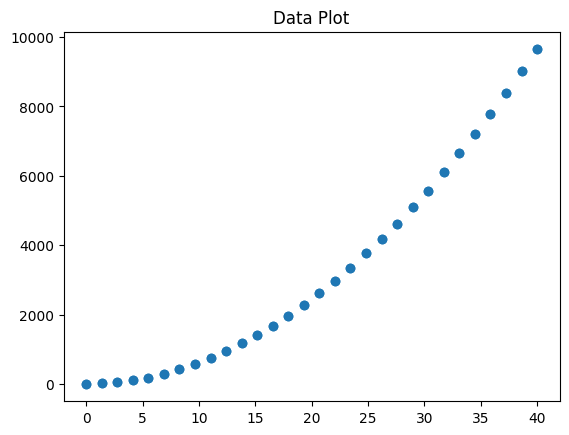

In [6]:
xmin,xmax = 0 , 40
N     = 30
sigma = 10

a,b = 6,2

data = genData(xmin,xmax,(a,b),sigma,N)

sigmay = [sigma for i in range(N)]

plt.title("Data Plot")
plt.scatter(data[0],data[1])
plt.errorbar(data[0],data[1], xerr=0,yerr=sigmay, linestyle = 'None', marker='o')
plt.show()

<h3>Fitting the data

In [7]:
dataFit = LeastSquares(data[0],data[1],sigmay,func1)

my_minuit = Minuit(dataFit,a=0,b=0)
my_minuit.migrad()
my_minuit.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 27.38 (χ²/ndof = 1.0)      │              Nfcn = 55               │
│ EDM = 2.48e-15 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   5.989   │   0.010   │            │            │         │         │       │
│ 1 │ b    │   2.34    │   0.31    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬───────────────────┐
│   │        a        b │
├───┼───────────────────┤
│ a │ 9.91e-05 -3.02e-3 │
│ b │ -3.02e-3   0.0984 │
└───┴───────────────────┘

In [8]:
a_est = my_minuit.values[0]
b_est = my_minuit.values[1]

Latex(f"$$a = {a} \\newline b = {b} \\newline a = {my_minuit.values[0]} \pm {a_est} \\newline b = {my_minuit.values[1]} \pm {b_est}$$")

<IPython.core.display.Latex object>

<h3>Quality of the fit

In [9]:
def Q_sqr(sample,sigma,func,a,b):
    
    sum = 0

    for x,y in zip(sample[0],sample[1]):
        
        sum += ((y-func(x,a,b))/sigma)**2
        
    return sum

In [10]:
Q_1 = Q_sqr(data,sigma,func1,a_est,b_est)

Q_2 = my_minuit.fval
N_dof = my_minuit.ndof

Latex(f"$$ \\newline Q_1 = {{{Q_1}}} \\newline Q_2 = {{{Q_2}}} \\newline d = {{{N_dof}}}$$")

<IPython.core.display.Latex object>

<h3> Toy Chi Distribution

In [38]:
def toy(xmin,xmax,a,b,sigma,N,n=10,func=func1):

    Q = np.zeros(N)

    sigmay = [sigma for i in range(n)]
    
    for i in range(N):

        d = genData(xmin,xmax,(a,b),sigma,n,func)

        Fit = LeastSquares(d[0],d[1],sigmay,func)

        fit_obj = Minuit(Fit,a=0,b=0)
        fit_obj.migrad()
        
        # Q[i] = fit_obj.fval

        Q[i] = Q_sqr(d,sigma,func,fit_obj.values[0],fit_obj.values[1])

        
    return Q

In [45]:
Chi_distribution = toy(xmin,xmax,a,b,sigma,10_000)

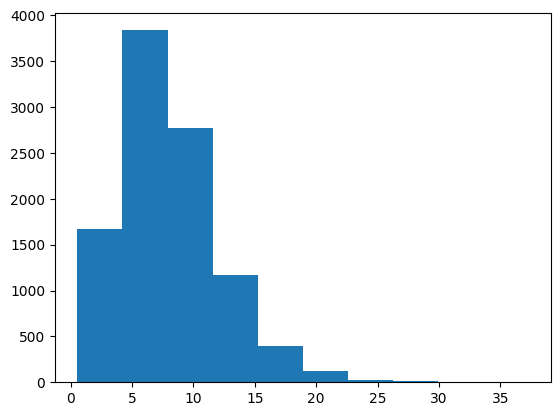

In [46]:
plt.hist(Chi_distribution)
plt.show()

In [51]:
doF = np.average(Chi_distribution)

Latex(f"$$\\text{{Degrees of freedom :\t}} {{{doF}}}$$")

<IPython.core.display.Latex object>